# **Identifying Key Entities in Recipe Data**


**Business Objective**:
The goal of this assignment is to train a Named Entity Recognition (NER) model using Conditional Random Fields (CRF) to extract key entities from recipe data. The model will classify words into predefined categories such as ingredients, quantities and units, enabling the creation of a structured database of recipes and ingredients that can be used to power advanced features in recipe management systems, dietary tracking apps, or e-commerce platforms.

### **Data Description**
The given data is in JSON format, representing a **structured recipe ingredient list** with **Named Entity Recognition (NER) labels**. Below is a breakdown of the data fields:

```json
[
    {
        "input": "6 Karela Bitter Gourd Pavakkai Salt 1 Onion 3 tablespoon Gram flour besan 2 teaspoons Turmeric powder Haldi Red Chilli Cumin seeds Jeera Coriander Powder Dhania Amchur Dry Mango Sunflower Oil",
        "pos": "quantity ingredient ingredient ingredient ingredient ingredient quantity ingredient quantity unit ingredient ingredient ingredient quantity unit ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient"
    },
    {
      "input": "2-1/2 cups rice cooked 3 tomatoes teaspoons BC Belle Bhat powder 1 teaspoon chickpea lentils 1/2 cumin seeds white urad dal mustard green chilli dry red 2 cashew or peanuts 1-1/2 tablespoon oil asafoetida",
      "pos": "quantity unit ingredient ingredient quantity ingredient unit ingredient ingredient ingredient ingredient quantity unit ingredient ingredient quantity ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient quantity ingredient ingredient ingredient quantity unit ingredient ingredient"
    }
]


| **Key**  | **Description**  |
|----------|-----------------|
| `input`  | Contains a raw ingredient list from a recipe. |
| `pos`    | Represents the corresponding part-of-speech (POS) tags or NER labels, identifying quantities, ingredients, and units. |


## **1** Import libraries

#### **1.1** Installation of sklearn-crfsuite

sklearn-crfsuite is a Python wrapper for CRFsuite, a fast and efficient implementation of Conditional Random Fields (CRFs). It is designed to integrate seamlessly with scikit-learn for structured prediction tasks such as Named Entity Recognition (NER), Part-of-Speech (POS) tagging, and chunking.

In [1]:
# installation of sklearn_crfsuite
!pip install sklearn_crfsuite==0.5.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 14.8 MB/s eta 0:00:00


#### **1.2** Import necessary libraries

In [2]:
# Import warnings
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Import necessary libraries
import json  # For handling JSON data
import pandas as pd  # For data manipulation and analysis
import re  # For regular expressions (useful for text preprocessing)
import matplotlib.pyplot as plt  # For visualisation
import seaborn as sns  # For advanced data visualisation
import sklearn_crfsuite  # CRF (Conditional Random Fields) implementation for sequence modeling
import numpy as np  # For numerical computations
# Saving and loading machine learning models
import joblib
import random
import spacy
from IPython.display import display, Markdown # For displaying well-formatted output

from fractions import Fraction  # For handling fractional values in numerical data
# Importing tools for feature engineering and model training
from collections import Counter  # For counting occurrences of elements in a list
from sklearn.model_selection import train_test_split  # For splitting dataset into train and test sets
from sklearn_crfsuite import metrics  # For evaluating CRF models
from sklearn_crfsuite.metrics import flat_classification_report
from sklearn.utils.class_weight import compute_class_weight
from collections import Counter
from sklearn.metrics import confusion_matrix

In [4]:
# Ensure pandas displays full content
pd.set_option('display.max_colwidth', None)
pd.set_option('display.expand_frame_repr', False)

## **2** Data Ingestion and Preparation <font color = red>[25 marks]</font> <br>

#### **2.1** *Read Recipe Data from Dataframe and prepare the data for analysis* <font color = red>[12 marks]</font> <br>
Read the data from JSON file, print first five rows and describe the dataframe

##### **2.1.1** **Define a *load_json_dataframe* function** <font color = red>[7 marks]</font> <br>

Define a function that takes path of the ingredient_and_quantity.json file and reads it, convert it into dataframe - df and return it.

In [5]:
# define a function to load json file to a dataframe
import json
from google.colab import drive
import os

drive.mount('/content/drive')
dir = '/content/drive/MyDrive/Colab Notebooks/NLP'
json_path = os.path.join(dir,'ingredient_and_quantity.json')

Mounted at /content/drive


In [6]:
def read_json_file(file_path,file_name):
  json_path = os.path.join(file_path,file_name)
  with open(json_path,'r') as file:
    df = pd.read_json(file)
  return df

##### **2.1.2** **Execute the *load_json_dataframe* function** <font color = red>[2 marks]</font> <br>

In [7]:
# read the json file by giving the file path and create a dataframe
json_df = read_json_file(dir,'ingredient_and_quantity.json')


##### **2.1.3** **Describe the dataframe** <font color = red>[3 marks]</font> <br>

Print first five rows of dataframe along with dimensions. Display the information of dataframe

In [8]:
# display first five rows of the dataframe - df
json_df.head()

,input,pos
0,6 Karela Bitter Gourd Pavakkai Salt 1 Onion 3 tablespoon Gram flour besan 2 teaspoons Turmeric powder Haldi Red Chilli Cumin seeds Jeera Coriander Powder Dhania Amchur Dry Mango Sunflower Oil,quantity ingredient ingredient ingredient ingredient ingredient quantity ingredient quantity unit ingredient ingredient ingredient quantity unit ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient
1,2-1/2 cups rice cooked 3 tomatoes teaspoons BC Belle Bhat powder 1 teaspoon chickpea lentils 1/2 cumin seeds white urad dal mustard green chilli dry red 2 cashew or peanuts 1-1/2 tablespoon oil asafoetida,quantity unit ingredient ingredient quantity ingredient unit ingredient ingredient ingredient ingredient quantity unit ingredient ingredient quantity ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient quantity ingredient ingredient ingredient quantity unit ingredient ingredient
2,1-1/2 cups Rice Vermicelli Noodles Thin 1 Onion sliced 1/2 cup Carrots Gajjar chopped 1/3 Green peas Matar 2 Chillies 1/4 teaspoon Asafoetida hing Mustard seeds White Urad Dal Split Ghee sprig Curry leaves Salt Lemon juice,quantity unit ingredient ingredient ingredient ingredient quantity ingredient ingredient quantity unit ingredient ingredient ingredient quantity ingredient ingredient ingredient quantity ingredient quantity unit ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient unit ingredient ingredient ingredient ingredient ingredient
3,500 grams Chicken 2 Onion chopped 1 Tomato 4 Green Chillies slit inch Ginger finely 6 cloves Garlic 1/2 teaspoon Turmeric powder Haldi Garam masala tablespoon Sesame Gingelly Oil 1/4 Methi Seeds Fenugreek Coriander Dhania Dry Red Fennel seeds Saunf cups Sorrel Leaves Gongura picked and,quantity unit ingredient quantity ingredient ingredient quantity ingredient quantity ingredient ingredient ingredient unit ingredient ingredient quantity unit ingredient quantity unit ingredient ingredient ingredient ingredient ingredient unit ingredient ingredient ingredient quantity ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient unit ingredient ingredient ingredient ingredient ingredient
4,1 tablespoon chana dal white urad 2 red chillies coriander seeds 3 inches ginger onion tomato Teaspoon mustard asafoetida sprig curry,quantity unit ingredient ingredient ingredient ingredient quantity ingredient ingredient ingredient ingredient quantity unit ingredient ingredient ingredient unit ingredient ingredient unit ingredient


In [9]:
# print the dimensions of dataframe - df
json_df.shape

(285, 2)

In [10]:
# print the information of the dataframe
json_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 285 entries, 0 to 284
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   input   285 non-null    object
 1   pos     285 non-null    object
dtypes: object(2)
memory usage: 4.6+ KB


#### **2.2** *Recipe Data Manipulation* <font color = red>[13 marks]</font> <br>
Create derived metrics in dataframe and provide insights of the dataframe

##### **2.2.1** **Create input_tokens and pos_tokens columns by splitting the input and pos from the dataframe** <font color = red>[3 marks]</font> <br>
Split the input and pos into input_tokens and pos_tokens in the dataframe and display it in the dataframe

In [11]:
# split the input and pos into input_tokens and pos_tokens in the dataframe

# Tokenize input
# Tokenize POS

from nltk.tokenize import word_tokenize
from nltk.stem.porter import PorterStemmer
from nltk.stem.snowball import SnowballStemmer
import nltk
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [12]:
json_df['input'] = json_df['input'].str.lower()

In [13]:
######applied word tokenization of each row of each column
json_df['input_json'] = json_df['input'].apply(word_tokenize)
json_df['pos_json'] = json_df['pos'].apply(word_tokenize)

In [14]:
# display first five rows of the dataframe - df
json_df.head()

,input,pos,input_json,pos_json
0,6 karela bitter gourd pavakkai salt 1 onion 3 tablespoon gram flour besan 2 teaspoons turmeric powder haldi red chilli cumin seeds jeera coriander powder dhania amchur dry mango sunflower oil,quantity ingredient ingredient ingredient ingredient ingredient quantity ingredient quantity unit ingredient ingredient ingredient quantity unit ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient,"[6, karela, bitter, gourd, pavakkai, salt, 1, onion, 3, tablespoon, gram, flour, besan, 2, teaspoons, turmeric, powder, haldi, red, chilli, cumin, seeds, jeera, coriander, powder, dhania, amchur, dry, mango, sunflower, oil]","[quantity, ingredient, ingredient, ingredient, ingredient, ingredient, quantity, ingredient, quantity, unit, ingredient, ingredient, ingredient, quantity, unit, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient]"
1,2-1/2 cups rice cooked 3 tomatoes teaspoons bc belle bhat powder 1 teaspoon chickpea lentils 1/2 cumin seeds white urad dal mustard green chilli dry red 2 cashew or peanuts 1-1/2 tablespoon oil asafoetida,quantity unit ingredient ingredient quantity ingredient unit ingredient ingredient ingredient ingredient quantity unit ingredient ingredient quantity ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient quantity ingredient ingredient ingredient quantity unit ingredient ingredient,"[2-1/2, cups, rice, cooked, 3, tomatoes, teaspoons, bc, belle, bhat, powder, 1, teaspoon, chickpea, lentils, 1/2, cumin, seeds, white, urad, dal, mustard, green, chilli, dry, red, 2, cashew, or, peanuts, 1-1/2, tablespoon, oil, asafoetida]","[quantity, unit, ingredient, ingredient, quantity, ingredient, unit, ingredient, ingredient, ingredient, ingredient, quantity, unit, ingredient, ingredient, quantity, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, quantity, ingredient, ingredient, ingredient, quantity, unit, ingredient, ingredient]"
2,1-1/2 cups rice vermicelli noodles thin 1 onion sliced 1/2 cup carrots gajjar chopped 1/3 green peas matar 2 chillies 1/4 teaspoon asafoetida hing mustard seeds white urad dal split ghee sprig curry leaves salt lemon juice,quantity unit ingredient ingredient ingredient ingredient quantity ingredient ingredient quantity unit ingredient ingredient ingredient quantity ingredient ingredient ingredient quantity ingredient quantity unit ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient unit ingredient ingredient ingredient ingredient ingredient,"[1-1/2, cups, rice, vermicelli, noodles, thin, 1, onion, sliced, 1/2, cup, carrots, gajjar, chopped, 1/3, green, peas, matar, 2, chillies, 1/4, teaspoon, asafoetida, hing, mustard, seeds, white, urad, dal, split, ghee, sprig, curry, leaves, salt, lemon, juice]","[quantity, unit, ingredient, ingredient, ingredient, ingredient, quantity, ingredient, ingredient, quantity, unit, ingredient, ingredient, ingredient, quantity, ingredient, ingredient, ingredient, quantity, ingredient, quantity, unit, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, unit, ingredient, ingredient, ingredient, ingredient, ingredient]"
3,500 grams chicken 2 onion chopped 1 tomato 4 green chillies slit inch ginger finely 6 cloves garlic 1/2 teaspoon turmeric powder haldi garam masala tablespoon sesame gingelly oil 1/4 methi seeds fenugreek coriander dhania dry red fennel seeds saunf cups sorrel leaves gongura picked and,quantity unit ingredient quantity ingredient ingredient quantity ingredient quantity ingredient ingredient ingredient unit ingredient ingredient quantit

##### **2.2.2** **Provide the length for input_tokens and pos_tokens and validate their length** <font color = red>[2 marks]</font> <br>

Create input_length and pos_length columns in the dataframe and validate both the lengths. Check for the rows that are unequal in input and pos length


In [15]:
# create input_length and pos_length columns for the input_tokens and pos-tokens
json_df['input_length'] = json_df['input_json'].apply(len)
json_df['pos_length'] = json_df['pos_json'].apply(len)

In [16]:
json_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 285 entries, 0 to 284
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   input         285 non-null    object
 1   pos           285 non-null    object
 2   input_json    285 non-null    object
 3   pos_json      285 non-null    object
 4   input_length  285 non-null    int64 
 5   pos_length    285 non-null    int64 
dtypes: int64(2), object(4)
memory usage: 13.5+ KB


In [17]:
# check for the equality of input_length and pos_length in the dataframe
print(json_df[json_df.pos_length != json_df.input_length][['input','pos','input_json','pos_json','input_length','pos_length']])

# 28 rows have mismatched in word and pos tokenizer.


                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              input                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     

##### **2.2.3** **Define a unique_labels function and validate the labels in pos_tokens** <font color = red>[2 marks]</font> <br>

Define a unique_labels function which checks for all the unique pos labels in the recipe & execute it.


In [18]:
# Define a unique_labels function to checks for all the unique pos labels in the recipe & print it
def unique_labels(column):
  all_labels = [tag for sublists in column for tag in sublists]
  return set(all_labels)

In [19]:
unique_labels = unique_labels(json_df['pos_json'])
print(unique_labels)

{'quantity', 'unit', 'ingredient'}


In [20]:
print(json_df[json_df.pos_length != json_df.input_length].index)

Index([ 17,  23,  27,  37,  42,  65,  69,  71,  77,  79,  86,  87, 114, 121,
       157, 163, 164, 173, 176, 183, 196, 205, 207, 218, 226, 239, 250, 277],
      dtype='int64')


##### **2.2.3** **Provide the insights seen in the recipe data after validation** <font color = red>[1 marks]</font> <br>

Provide the indexes that requires cleaning and formatting in the dataframe

<font color = red>[write your answer]</font> <br>
*the definition is based upon the mismatch between input length and pos length*
<br>
Index([ 17,  23,  27,  37,  42,  65,  69,  71,  77,  79,  86,  87, 114, 121,
       157, 163, 164, 173, 176, 183, 196, 205, 207, 218, 226, 239, 250, 277],
      dtype='int64')

##### **2.2.4** **Drop the rows that have invalid data provided in previous cell** <font color = red> [2 marks]</font> <br>

In [21]:
# drop the irrelevant recipe data
recipe_df = json_df[json_df.pos_length == json_df.input_length]
recipe_df.head()

,input,pos,input_json,pos_json,input_length,pos_length
0,6 karela bitter gourd pavakkai salt 1 onion 3 tablespoon gram flour besan 2 teaspoons turmeric powder haldi red chilli cumin seeds jeera coriander powder dhania amchur dry mango sunflower oil,quantity ingredient ingredient ingredient ingredient ingredient quantity ingredient quantity unit ingredient ingredient ingredient quantity unit ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient,"[6, karela, bitter, gourd, pavakkai, salt, 1, onion, 3, tablespoon, gram, flour, besan, 2, teaspoons, turmeric, powder, haldi, red, chilli, cumin, seeds, jeera, coriander, powder, dhania, amchur, dry, mango, sunflower, oil]","[quantity, ingredient, ingredient, ingredient, ingredient, ingredient, quantity, ingredient, quantity, unit, ingredient, ingredient, ingredient, quantity, unit, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient]",31,31
1,2-1/2 cups rice cooked 3 tomatoes teaspoons bc belle bhat powder 1 teaspoon chickpea lentils 1/2 cumin seeds white urad dal mustard green chilli dry red 2 cashew or peanuts 1-1/2 tablespoon oil asafoetida,quantity unit ingredient ingredient quantity ingredient unit ingredient ingredient ingredient ingredient quantity unit ingredient ingredient quantity ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient quantity ingredient ingredient ingredient quantity unit ingredient ingredient,"[2-1/2, cups, rice, cooked, 3, tomatoes, teaspoons, bc, belle, bhat, powder, 1, teaspoon, chickpea, lentils, 1/2, cumin, seeds, white, urad, dal, mustard, green, chilli, dry, red, 2, cashew, or, peanuts, 1-1/2, tablespoon, oil, asafoetida]","[quantity, unit, ingredient, ingredient, quantity, ingredient, unit, ingredient, ingredient, ingredient, ingredient, quantity, unit, ingredient, ingredient, quantity, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, quantity, ingredient, ingredient, ingredient, quantity, unit, ingredient, ingredient]",34,34
2,1-1/2 cups rice vermicelli noodles thin 1 onion sliced 1/2 cup carrots gajjar chopped 1/3 green peas matar 2 chillies 1/4 teaspoon asafoetida hing mustard seeds white urad dal split ghee sprig curry leaves salt lemon juice,quantity unit ingredient ingredient ingredient ingredient quantity ingredient ingredient quantity unit ingredient ingredient ingredient quantity ingredient ingredient ingredient quantity ingredient quantity unit ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient unit ingredient ingredient ingredient ingredient ingredient,"[1-1/2, cups, rice, vermicelli, noodles, thin, 1, onion, sliced, 1/2, cup, carrots, gajjar, chopped, 1/3, green, peas, matar, 2, chillies, 1/4, teaspoon, asafoetida, hing, mustard, seeds, white, urad, dal, split, ghee, sprig, curry, leaves, salt, lemon, juice]","[quantity, unit, ingredient, ingredient, ingredient, ingredient, quantity, ingredient, ingredient, quantity, unit, ingredient, ingredient, ingredient, quantity, ingredient, ingredient, ingredient, quantity, ingredient, quantity, unit, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, unit, ingredient, ingredient, ingredient, ingredient, ingredient]",37,37
3,500 grams chicken 2 onion chopped 1 tomato 4 green chillies slit inch ginger finely 6 cloves garlic 1/2 teaspoon turmeric powder haldi garam masala tablespoon sesame gingelly oil 1/4 methi seeds fenugreek coriander dhania dry red fennel seeds saunf cups sorrel leaves gongura picked and,quantity unit ingredient quantity ingredient ingredient quantity ingredient quantity ingredient ingredient ing

In [22]:
# Remove stop words, special characters from the rows before the transformation.
# nltk.download('stopwords')
# from nltk.corpus import stopwords
# en_stopwords = stopwords.words('english')
# print(en_stopwords)

# def remove_stopwords(pos_json):
#   return_lst = [token for token in pos_json if token not in en_stopwords]
#   return return_lst

# print(json_df['input_json'].apply(remove_stopwords))

##### **2.2.5** **Update the input_length & pos_length in dataframe**<font color = red> [2 marks]</font> <br>

In [23]:
# update the input and pos length in input_length and pos_length
recipe_df['input_length'] = recipe_df['input'].apply(len)
recipe_df['pos_length'] = recipe_df['pos'].apply(len)

In [24]:
recipe_df.head()

,input,pos,input_json,pos_json,input_length,pos_length
0,6 karela bitter gourd pavakkai salt 1 onion 3 tablespoon gram flour besan 2 teaspoons turmeric powder haldi red chilli cumin seeds jeera coriander powder dhania amchur dry mango sunflower oil,quantity ingredient ingredient ingredient ingredient ingredient quantity ingredient quantity unit ingredient ingredient ingredient quantity unit ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient,"[6, karela, bitter, gourd, pavakkai, salt, 1, onion, 3, tablespoon, gram, flour, besan, 2, teaspoons, turmeric, powder, haldi, red, chilli, cumin, seeds, jeera, coriander, powder, dhania, amchur, dry, mango, sunflower, oil]","[quantity, ingredient, ingredient, ingredient, ingredient, ingredient, quantity, ingredient, quantity, unit, ingredient, ingredient, ingredient, quantity, unit, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient]",191,320
1,2-1/2 cups rice cooked 3 tomatoes teaspoons bc belle bhat powder 1 teaspoon chickpea lentils 1/2 cumin seeds white urad dal mustard green chilli dry red 2 cashew or peanuts 1-1/2 tablespoon oil asafoetida,quantity unit ingredient ingredient quantity ingredient unit ingredient ingredient ingredient ingredient quantity unit ingredient ingredient quantity ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient quantity ingredient ingredient ingredient quantity unit ingredient ingredient,"[2-1/2, cups, rice, cooked, 3, tomatoes, teaspoons, bc, belle, bhat, powder, 1, teaspoon, chickpea, lentils, 1/2, cumin, seeds, white, urad, dal, mustard, green, chilli, dry, red, 2, cashew, or, peanuts, 1-1/2, tablespoon, oil, asafoetida]","[quantity, unit, ingredient, ingredient, quantity, ingredient, unit, ingredient, ingredient, ingredient, ingredient, quantity, unit, ingredient, ingredient, quantity, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, quantity, ingredient, ingredient, ingredient, quantity, unit, ingredient, ingredient]",204,337
2,1-1/2 cups rice vermicelli noodles thin 1 onion sliced 1/2 cup carrots gajjar chopped 1/3 green peas matar 2 chillies 1/4 teaspoon asafoetida hing mustard seeds white urad dal split ghee sprig curry leaves salt lemon juice,quantity unit ingredient ingredient ingredient ingredient quantity ingredient ingredient quantity unit ingredient ingredient ingredient quantity ingredient ingredient ingredient quantity ingredient quantity unit ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient unit ingredient ingredient ingredient ingredient ingredient,"[1-1/2, cups, rice, vermicelli, noodles, thin, 1, onion, sliced, 1/2, cup, carrots, gajjar, chopped, 1/3, green, peas, matar, 2, chillies, 1/4, teaspoon, asafoetida, hing, mustard, seeds, white, urad, dal, split, ghee, sprig, curry, leaves, salt, lemon, juice]","[quantity, unit, ingredient, ingredient, ingredient, ingredient, quantity, ingredient, ingredient, quantity, unit, ingredient, ingredient, ingredient, quantity, ingredient, ingredient, ingredient, quantity, ingredient, quantity, unit, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, unit, ingredient, ingredient, ingredient, ingredient, ingredient]",222,370
3,500 grams chicken 2 onion chopped 1 tomato 4 green chillies slit inch ginger finely 6 cloves garlic 1/2 teaspoon turmeric powder haldi garam masala tablespoon sesame gingelly oil 1/4 methi seeds fenugreek coriander dhania dry red fennel seeds saunf cups sorrel leaves gongura picked and,quantity unit ingredient quantity ingredient ingredient quantity ingredient quantity ingredient ingredie

##### **2.2.6** **Validate the input_length and pos_length by checking unequal rows** <font color = red> [1 marks]</font> <br>

In [25]:
# validate the input length and pos length as input_length and pos_length
result_input = []
result_pos = []
for index, row in recipe_df.iterrows():
  if row['input_length'] != len(row['input']):
    result_input.append(index)
  if row['pos_length'] != len(row['pos']):
    result_pos.append(index)

print(result_input)
print(result_pos)

[]
[]


## **3** Train Validation Split (70 train - 30 val) <font color = red>[6 marks]</font> <br>

#### **3.1** *Perform train and validation split ratio* <font color = red>[6 marks]</font> <br>
Split the dataset with the help of input_tokens and pos_tokens and make a ratio of 70:30 split for training and validation datasets.

###### **3.1.1** **Split the dataset into train_df and val_df into 70:30 ratio** <font color = red> [1 marks]</font> <br>

In [26]:
# split the dataset into training and validation sets
shape_recipe = len(recipe_df)
split_row = int(shape_recipe*0.7)

train_recipe_df = recipe_df.iloc[:split_row]
val_recipe_df = recipe_df.iloc[split_row:]

print(train_recipe_df.shape)
print(val_recipe_df.shape)

(179, 6)
(78, 6)


###### **3.1.2** **Print the first five rows of train_df and val_df** <font color = red> [1 marks]</font> <br>

In [27]:
# print the first five rows of train_df
train_recipe_df.head()

,input,pos,input_json,pos_json,input_length,pos_length
0,6 karela bitter gourd pavakkai salt 1 onion 3 tablespoon gram flour besan 2 teaspoons turmeric powder haldi red chilli cumin seeds jeera coriander powder dhania amchur dry mango sunflower oil,quantity ingredient ingredient ingredient ingredient ingredient quantity ingredient quantity unit ingredient ingredient ingredient quantity unit ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient,"[6, karela, bitter, gourd, pavakkai, salt, 1, onion, 3, tablespoon, gram, flour, besan, 2, teaspoons, turmeric, powder, haldi, red, chilli, cumin, seeds, jeera, coriander, powder, dhania, amchur, dry, mango, sunflower, oil]","[quantity, ingredient, ingredient, ingredient, ingredient, ingredient, quantity, ingredient, quantity, unit, ingredient, ingredient, ingredient, quantity, unit, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient]",191,320
1,2-1/2 cups rice cooked 3 tomatoes teaspoons bc belle bhat powder 1 teaspoon chickpea lentils 1/2 cumin seeds white urad dal mustard green chilli dry red 2 cashew or peanuts 1-1/2 tablespoon oil asafoetida,quantity unit ingredient ingredient quantity ingredient unit ingredient ingredient ingredient ingredient quantity unit ingredient ingredient quantity ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient quantity ingredient ingredient ingredient quantity unit ingredient ingredient,"[2-1/2, cups, rice, cooked, 3, tomatoes, teaspoons, bc, belle, bhat, powder, 1, teaspoon, chickpea, lentils, 1/2, cumin, seeds, white, urad, dal, mustard, green, chilli, dry, red, 2, cashew, or, peanuts, 1-1/2, tablespoon, oil, asafoetida]","[quantity, unit, ingredient, ingredient, quantity, ingredient, unit, ingredient, ingredient, ingredient, ingredient, quantity, unit, ingredient, ingredient, quantity, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, quantity, ingredient, ingredient, ingredient, quantity, unit, ingredient, ingredient]",204,337
2,1-1/2 cups rice vermicelli noodles thin 1 onion sliced 1/2 cup carrots gajjar chopped 1/3 green peas matar 2 chillies 1/4 teaspoon asafoetida hing mustard seeds white urad dal split ghee sprig curry leaves salt lemon juice,quantity unit ingredient ingredient ingredient ingredient quantity ingredient ingredient quantity unit ingredient ingredient ingredient quantity ingredient ingredient ingredient quantity ingredient quantity unit ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient unit ingredient ingredient ingredient ingredient ingredient,"[1-1/2, cups, rice, vermicelli, noodles, thin, 1, onion, sliced, 1/2, cup, carrots, gajjar, chopped, 1/3, green, peas, matar, 2, chillies, 1/4, teaspoon, asafoetida, hing, mustard, seeds, white, urad, dal, split, ghee, sprig, curry, leaves, salt, lemon, juice]","[quantity, unit, ingredient, ingredient, ingredient, ingredient, quantity, ingredient, ingredient, quantity, unit, ingredient, ingredient, ingredient, quantity, ingredient, ingredient, ingredient, quantity, ingredient, quantity, unit, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, unit, ingredient, ingredient, ingredient, ingredient, ingredient]",222,370
3,500 grams chicken 2 onion chopped 1 tomato 4 green chillies slit inch ginger finely 6 cloves garlic 1/2 teaspoon turmeric powder haldi garam masala tablespoon sesame gingelly oil 1/4 methi seeds fenugreek coriander dhania dry red fennel seeds saunf cups sorrel leaves gongura picked and,quantity unit ingredient quantity ingredient ingredient quantity ingredient quantity ingredient ingredie

In [28]:
# print the first five rows of the val_df
val_recipe_df.head()

,input,pos,input_json,pos_json,input_length,pos_length
200,4 tomatoes 2 sprig curry leaves green chillies 1/2 tsp turmeric powder 1 coriander salt rock sugar a pinch,quantity ingredient quantity unit ingredient ingredient ingredient ingredient quantity unit ingredient ingredient quantity ingredient ingredient ingredient ingredient quantity unit,"[4, tomatoes, 2, sprig, curry, leaves, green, chillies, 1/2, tsp, turmeric, powder, 1, coriander, salt, rock, sugar, a, pinch]","[quantity, ingredient, quantity, unit, ingredient, ingredient, ingredient, ingredient, quantity, unit, ingredient, ingredient, quantity, ingredient, ingredient, ingredient, ingredient, quantity, unit]",106,180
201,500 grams gunde bird lime 1 teaspoon methi seeds fenugreek 1/2 cumin seeds jeera asafoetida hing fennel saunf mustard turmeric powder haldi red chilli amchur dry mango powder coriander dhania leaves few,quantity unit ingredient ingredient ingredient quantity unit ingredient ingredient ingredient quantity ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient,"[500, grams, gunde, bird, lime, 1, teaspoon, methi, seeds, fenugreek, 1/2, cumin, seeds, jeera, asafoetida, hing, fennel, saunf, mustard, turmeric, powder, haldi, red, chilli, amchur, dry, mango, powder, coriander, dhania, leaves, few]","[quantity, unit, ingredient, ingredient, ingredient, quantity, unit, ingredient, ingredient, ingredient, quantity, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient]",202,333
202,200 grams jackfruit raw kathal 1 onion sliced 4 cloves garlic chopped inch ginger tablespoon cumin powder jeera teaspoon black pepper 1/2 cinnamon powder dalchini 2 paprika turmeric haldi cup rajma large kidney beans soaked boiled tomato red chilli sugar 1/4 cooked rice dried thyme leaves bell capsicum yellow pepper green sour cream salsa tortillas,quantity unit ingredient ingredient ingredient quantity ingredient ingredient quantity unit ingredient ingredient unit ingredient unit ingredient ingredient ingredient unit ingredient ingredient quantity ingredient ingredient ingredient quantity ingredient ingredient ingredient unit ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient quantity ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient,"[200, grams, jackfruit, raw, kathal, 1, onion, sliced, 4, cloves, garlic, chopped, inch, ginger, tablespoon, cumin, powder, jeera, teaspoon, black, pepper, 1/2, cinnamon, powder, dalchini, 2, paprika, turmeric, haldi, cup, rajma, large, kidney, beans, soaked, boiled, tomato, red, chilli, sugar, 1/4, cooked, rice, dried, thyme, leaves, bell, capsicum, yellow, pepper, green, sour, cream, salsa, tortillas]","[quantity, unit, ingredient, ingredient, ingredient, quantity, ingredient, ingredient, quantity, unit, ingredient, ingredient, unit, ingredient, unit, ingredient, ingredient, ingredient, unit, ingredient, ingredient, quantity, ingredient, ingredient, ingredient, quantity, ingredient, ingredient, ingredient, unit, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, quantity, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient]",350,556
203,1/2 cup green beans chopped steam carrots 1 cabbage steamed potatoes boiled 6 cloves garlic 2 inch ginger onion chilies cups rice wash tomato-puree curd cinnamon 4 cardamom bay leaves tsp turmeric powder red c

###### **3.1.3** **Extract the dataset into train_df and val_df into X_train, X_val, y_train and y_val and display their length** <font color = red> [2 marks]</font> <br>

Extract X_train, X_val, y_train and y_val by extracting the list of input_tokens and pos_tokens from train_df and val_df and also display their length

In [29]:
# extract the training and validation sets by taking input_tokens and pos_tokens
X_train = train_recipe_df[['input_json']]
y_train = train_recipe_df[['pos_json']]
X_val = val_recipe_df[['input_json']]
y_val = val_recipe_df[['pos_json']]

In [30]:
# validate the shape of training and validation samples
print(X_train.shape, X_val.shape, y_train.shape, y_val.shape)

(179, 1) (78, 1) (179, 1) (78, 1)


In [31]:
len(X_train['input_json'].iloc[0])

31

In [32]:
len(y_train['pos_json'].iloc[0])

31

###### **3.1.4** **Display the number of unique labels present in y_train** <font color = red> [2 marks]</font> <br>

In [33]:
# Display the number of unique labels present in y_train
print(set([tag for sublists in y_train['pos_json'] for tag in sublists]))

{'quantity', 'unit', 'ingredient'}


## **4** Exploratory Recipe Data Analysis on Training Dataset <font color = red>[16 marks]</font> <br>

#### **4.1** *Flatten the lists for input_tokens & pos_tokens* <font color = red>[2 marks]</font> <br>

Define a function **flatten_list** for flattening the structure for input_tokens and pos_tokens. The input parameter passed to this function is a nested list.

Initialise the dataset_name with a value ***'Training'***




In [34]:
# flatten the list for nested_list (input_tokens, pos_tokens)
Training = pd.merge(X_train,y_train, left_index = True, right_index = True)
Training.head()

,input_json,pos_json
0,"[6, karela, bitter, gourd, pavakkai, salt, 1, onion, 3, tablespoon, gram, flour, besan, 2, teaspoons, turmeric, powder, haldi, red, chilli, cumin, seeds, jeera, coriander, powder, dhania, amchur, dry, mango, sunflower, oil]","[quantity, ingredient, ingredient, ingredient, ingredient, ingredient, quantity, ingredient, quantity, unit, ingredient, ingredient, ingredient, quantity, unit, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient]"
1,"[2-1/2, cups, rice, cooked, 3, tomatoes, teaspoons, bc, belle, bhat, powder, 1, teaspoon, chickpea, lentils, 1/2, cumin, seeds, white, urad, dal, mustard, green, chilli, dry, red, 2, cashew, or, peanuts, 1-1/2, tablespoon, oil, asafoetida]","[quantity, unit, ingredient, ingredient, quantity, ingredient, unit, ingredient, ingredient, ingredient, ingredient, quantity, unit, ingredient, ingredient, quantity, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, quantity, ingredient, ingredient, ingredient, quantity, unit, ingredient, ingredient]"
2,"[1-1/2, cups, rice, vermicelli, noodles, thin, 1, onion, sliced, 1/2, cup, carrots, gajjar, chopped, 1/3, green, peas, matar, 2, chillies, 1/4, teaspoon, asafoetida, hing, mustard, seeds, white, urad, dal, split, ghee, sprig, curry, leaves, salt, lemon, juice]","[quantity, unit, ingredient, ingredient, ingredient, ingredient, quantity, ingredient, ingredient, quantity, unit, ingredient, ingredient, ingredient, quantity, ingredient, ingredient, ingredient, quantity, ingredient, quantity, unit, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, unit, ingredient, ingredient, ingredient, ingredient, ingredient]"
3,"[500, grams, chicken, 2, onion, chopped, 1, tomato, 4, green, chillies, slit, inch, ginger, finely, 6, cloves, garlic, 1/2, teaspoon, turmeric, powder, haldi, garam, masala, tablespoon, sesame, gingelly, oil, 1/4, methi, seeds, fenugreek, coriander, dhania, dry, red, fennel, seeds, saunf, cups, sorrel, leaves, gongura, picked, and]","[quantity, unit, ingredient, quantity, ingredient, ingredient, quantity, ingredient, quantity, ingredient, ingredient, ingredient, unit, ingredient, ingredient, quantity, unit, ingredient, quantity, unit, ingredient, ingredient, ingredient, ingredient, ingredient, unit, ingredient, ingredient, ingredient, quantity, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, unit, ingredient, ingredient, ingredient, ingredient, ingredient]"
4,"[1, tablespoon, chana, dal, white, urad, 2, red, chillies, coriander, seeds, 3, inches, ginger, onion, tomato, teaspoon, mustard, asafoetida, sprig, curry]","[quantity, unit, ingredient, ingredient, ingredient, ingredient, quantity, ingredient, ingredient, ingredient, ingredient, quantity, unit, ingredient, ingredient, ingredient, unit, ingredient, ingredient, unit, ingredient]"


In [35]:
def flatten_list(df, input_json, pos_json):
  flat_col1 = [item for sublist in df[input_json] for item in sublist]
  flat_col2 = [item for sublist in df[pos_json] for item in sublist]
  flattened_df = pd.DataFrame(list(zip(flat_col1, flat_col2)), columns = ['input','tag'])
  return flattened_df

In [36]:
flattened = flatten_list(Training, 'input_json', 'pos_json')

In [37]:
flattened.head()

,input,tag
0,6,quantity
1,karela,ingredient
2,bitter,ingredient
3,gourd,ingredient
4,pavakkai,ingredient


In [38]:
# initialise the dataset_name
Training = pd.merge(X_train,y_train, left_index = True, right_index = True)
Validation = pd.merge(X_val,y_val, left_index = True, right_index = True)

#### **4.2** *Extract and validate the tokens after using the flattening technique* <font color = red>[2 marks]</font> <br>

Define a function named ***extract_and_validate_tokens*** with parameters dataframe and dataset_name (Training/Validation), validate the length of input_tokens and pos_tokens from dataframe and display first 10 records for both the input_tokens and pos_tokens. Execute this function




In [39]:
# define a extract_and_validate_tokens with parameters (df, dataset_name)
# call the flatten_list and apply it on input_tokens and pos_tokens
# validate their length and display first 10 records having input and pos tokens
def extract_validate_tokens(df):
  flattened_df = flatten_list(df, 'input_json', 'pos_json')
  print(flattened_df.shape)
  print(flattened_df.head(10))
  return flattened_df



In [40]:
# extract the tokens and its pos tags
extract_tokens = extract_validate_tokens(Training)

(6190, 2)
        input         tag
0           6    quantity
1      karela  ingredient
2      bitter  ingredient
3       gourd  ingredient
4    pavakkai  ingredient
5        salt  ingredient
6           1    quantity
7       onion  ingredient
8           3    quantity
9  tablespoon        unit


In [41]:
extract_tokens.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6190 entries, 0 to 6189
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   input   6190 non-null   object
 1   tag     6190 non-null   object
dtypes: object(2)
memory usage: 96.8+ KB


#### **4.3** *Categorise tokens into labels (unit, ingredient, quantity)* <font color = red>[2 marks]</font> <br>

Define a function ***categorize_tokens*** to categorise tokens into ingredients, units and quantities by using extracted tokens in the previous code and return a list of ingredients, units and quantities. Execute this function to get the list.



In [42]:
# define a categorize_tokens function and provide the tokens and pos_tags as parameters and create ingredient, unit and quantity list and return it
# validate the list that it comprised of these labels, if not return empty arrays

def categorize_tokens(df,input,tag):
  ingredient = df[df[tag]== 'ingredient'][input]
  unit = df[df[tag]== 'unit'][input]
  quantity = df[df[tag]== 'quantity'][input]
  return list(ingredient), list(unit), list(quantity)


In [43]:
#  call the function to categorise the labels into respective list
ingredient, unit, quantity = categorize_tokens(extract_tokens, 'input', 'tag' )

In [44]:
print(len(ingredient))
print(len(unit))
print(len(quantity))


4579
736
875


#### **4.4** *Top 10 Most Frequent Items* <font color = red>[3 marks]</font> <br>

Define a function ***get_top_frequent_items*** to display top 10 most frequent items

Here, item_list is used as a general parameter where you will call this function for ingredient and unit list

Execute this function separately for top 10 most units and ingredients



In [45]:
# define a function get_top_frequent_items to get the top frequent items by using item_list, pos label and dataset_name(Training/Validation) and return top items
from collections import Counter
def get_top_frequent_items(df, top_n = 10):
  extract_tokens = extract_validate_tokens(df)
  ingredient, unit, quantity = categorize_tokens(extract_tokens, 'input', 'tag' )
  ingredient_10 = Counter(ingredient).most_common(top_n)
  unit_10 = Counter(unit).most_common(top_n)
  return ingredient_10, unit_10



In [46]:
# get the top ingredients which are frequently seen in the recipe
top_items = get_top_frequent_items(Training, top_n = 15)



(6190, 2)
        input         tag
0           6    quantity
1      karela  ingredient
2      bitter  ingredient
3       gourd  ingredient
4    pavakkai  ingredient
5        salt  ingredient
6           1    quantity
7       onion  ingredient
8           3    quantity
9  tablespoon        unit


In [47]:
# get the top units which are frequently seen in the recipe
print(top_items)

([('powder', 167), ('salt', 115), ('seeds', 115), ('leaves', 109), ('oil', 105), ('red', 101), ('coriander', 86), ('green', 84), ('chilli', 81), ('chopped', 73), ('garlic', 73), ('chillies', 72), ('turmeric', 71), ('cumin', 71), ('ginger', 66)], [('teaspoon', 142), ('cup', 118), ('tablespoon', 86), ('tablespoons', 61), ('cups', 49), ('grams', 49), ('inch', 47), ('sprig', 41), ('cloves', 34), ('teaspoons', 32), ('pinch', 16), ('tsp', 12), ('tbsp', 5), ('spoon', 4), ('small', 4)])


#### **4.5** *Plot Top 10 most frequent items* <font color = red>[2 marks]</font> <br>




Define a function ***plot_top_items*** to plot a bar graph on top 10 most frequent items for units and ingredients

Here, item_list is used as a general parameter where you will call this function for ingredient and unit list

In [48]:
# define plot top items with parameters - top_item list, label to suggest whether its ingredient or unit, dataset_name
def plot_top_items(label,df, top_item = None):
  if top_item is None:
        top_item = get_top_frequent_items(df, top_n=10)

  if label == 'ingredient':
    top_item = top_items[0]
  else:
    top_item = top_items[1]
  X = [item[0] for item in top_item]
  Y = [item[1] for item in top_item]
  plt.figure(figsize = (30,10))
  plt.bar(X,Y)

#### **4.6** *Perform EDA analysis* <font color = red>[5 marks]</font> <br>

Plot the bar plots for ingredients and units and provide the insights for training dataset

---



(6190, 2)
        input         tag
0           6    quantity
1      karela  ingredient
2      bitter  ingredient
3       gourd  ingredient
4    pavakkai  ingredient
5        salt  ingredient
6           1    quantity
7       onion  ingredient
8           3    quantity
9  tablespoon        unit


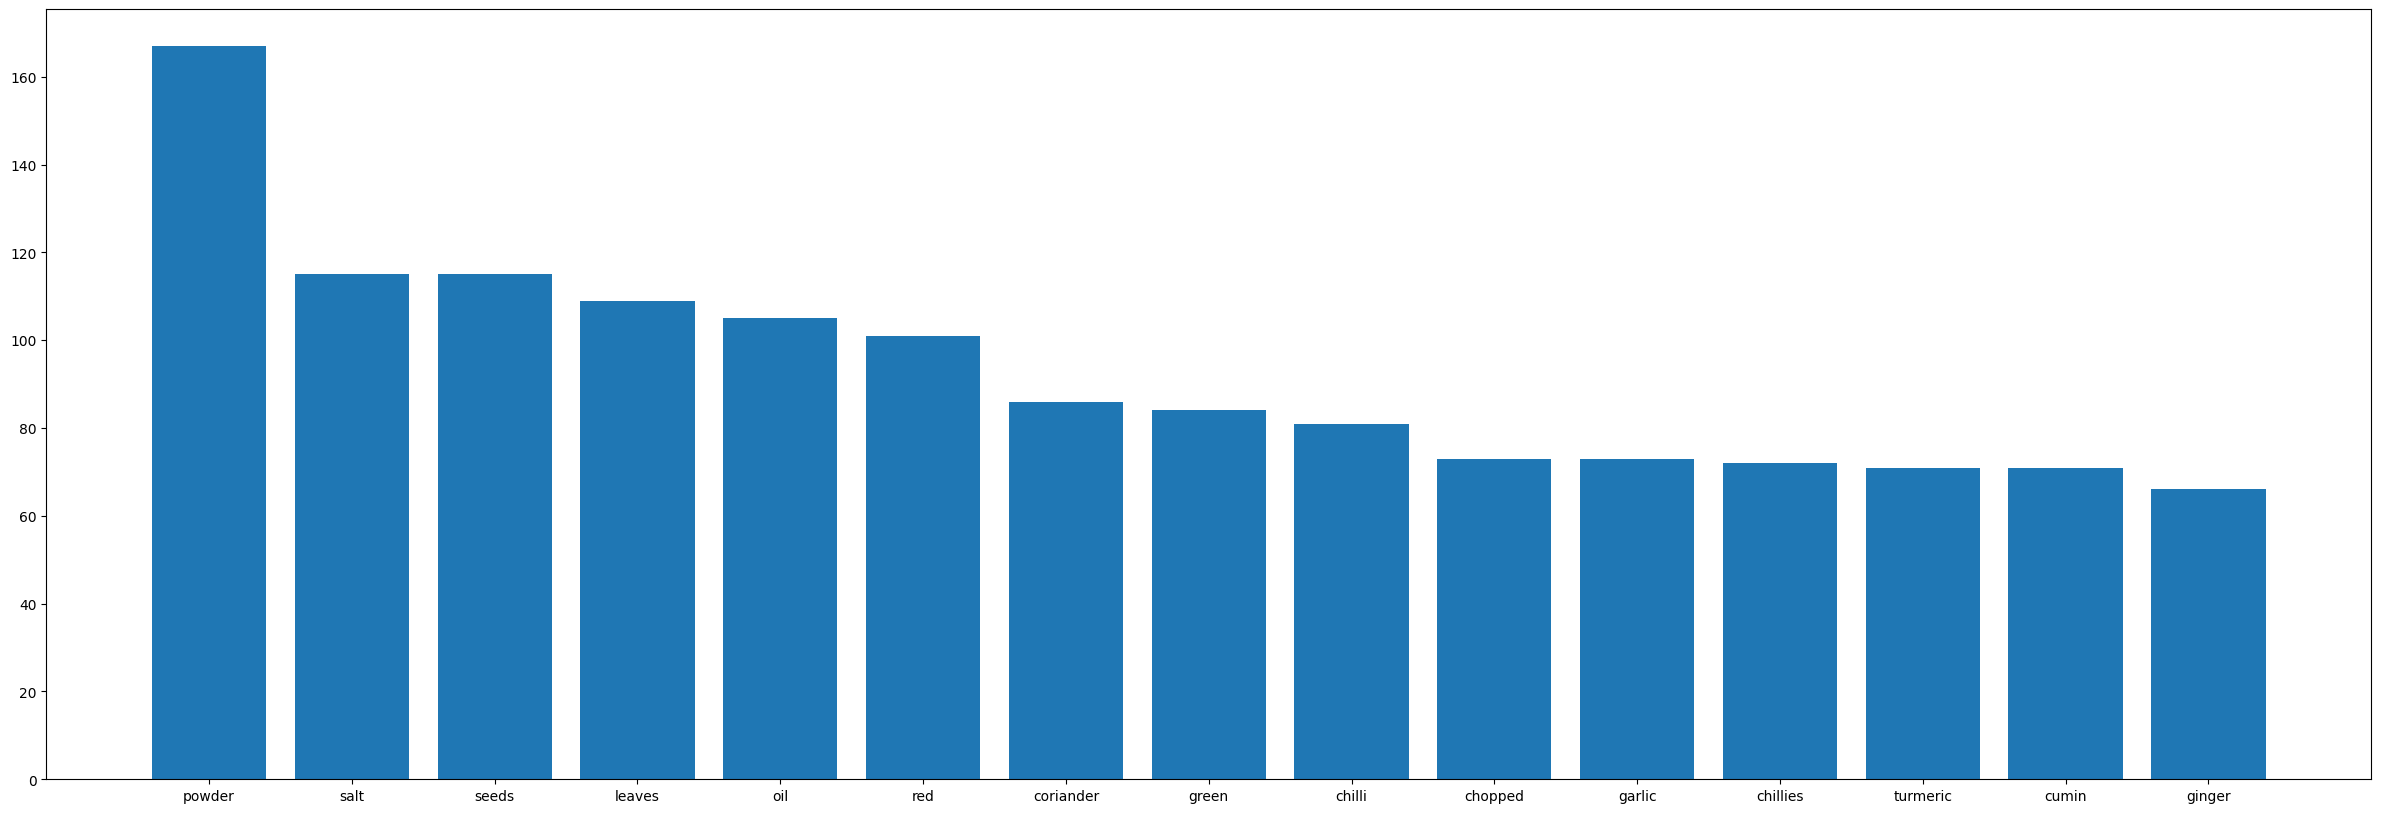

In [49]:
# plot the top frequent ingredients in training data
plot_top_items('ingredient',Training, top_item = None)

(6190, 2)
        input         tag
0           6    quantity
1      karela  ingredient
2      bitter  ingredient
3       gourd  ingredient
4    pavakkai  ingredient
5        salt  ingredient
6           1    quantity
7       onion  ingredient
8           3    quantity
9  tablespoon        unit


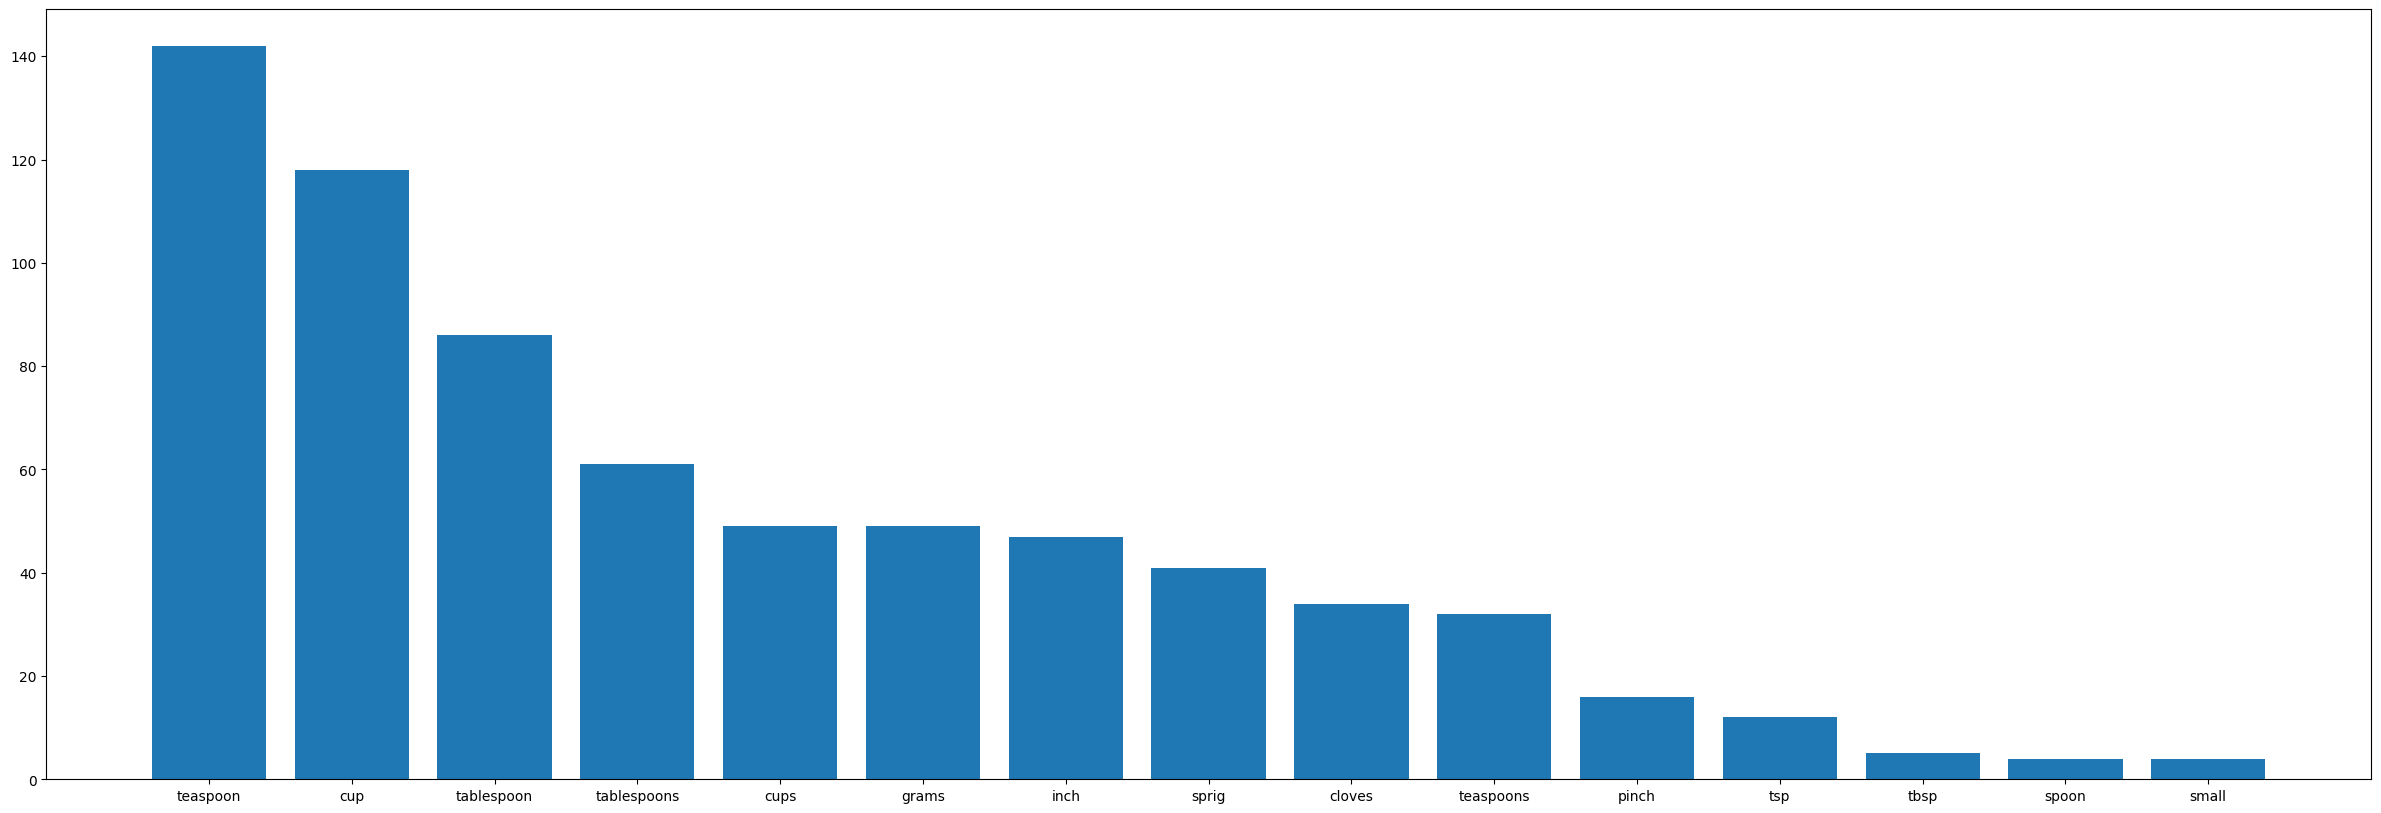

In [50]:
# plot the top frequent units in training data
plot_top_items('units',Training, top_item = None)

## **5** Exploratory Recipe Data Analysis on Validation Dataset (Optional)<font color = red> [0 marks]</font> <br>

#### **5.1** *Execute EDA on Validation Dataset with insights (Optional)* <font color = red> [0 marks]</font> <br>
Initialise the dataset_name as ***Validation*** and call the ***plot_top_items*** for top 10 ingredients and units in the recipe data
Provide the insights for the same.



In [51]:
# initialise the dataset_name


In [52]:
# use extract and validate tokens, categorise tokens, get top frequent items for ingredient list and unit list on validation dataframe


In [53]:
# plot the top frequent ingredients in validation data


In [54]:
# plot the top frequent units in training data


## **6** Feature Extraction For CRF Model <font color = red>[30 marks]</font> <br>

### **6.1** *Define a feature functions to take each token from recipe* <font color = red>[10 marks]</font>

Define a function as ***word2features*** which takes a particular recipe and its index to work with all recipe input tokens and include custom key-value pairs.

Also, use feature key-value pairs to mark the beginning and end of the sequence and to also check whether the word belongs to unit, quantity etc. Use keyword sets for unit and quantity for differentiating feature functions well. Also make use of relevant regex patterns on fractions, whole numbers etc.

##### **6.1.1** **Define keywords for unit and quantity and create a quantity pattern to work on fractions, numbers and decimals** <font color = red>[3 marks]</font> <br>

Create sets for **unit_keywords** and ***quantity_keywords*** and include all the words relevant for measuring the ingredients such as cup, tbsp, tsp etc. and in quantity keywords, include words such as half, quarter etc.

Also suggested to use regex pattern as ***quantity_pattern*** to work with quantity in any format such as fractions, numbers and decimals.

Then, load the spacy model and process the entire sentence

In [55]:
# define unit and quantity keywords along with quantity pattern
unit_keywords = {
    "cup", "cups", "tablespoon", "tablespoons", "tbsp", "tbsps",
    "teaspoon", "teaspoons", "tsp", "tsps", "oz", "ounce", "ounces",
    "gram", "grams", "g", "kg", "ml", "milliliter", "milliliters", "l", "litre", "litres",
    "pinch", "clove", "cloves", "can", "cans", "slice", "slices", "stick", "sticks",
    "dash", "package", "packages", "quart", "quarts", "pint", "pints"
}
quantity_keywords = {
    "half", "quarter", "third", "fourth", "one", "two", "three", "four", "five",
    "six", "seven", "eight", "nine", "ten", "a", "an"
}

import re
quantity_pattern = re.compile(r'\d+(?:\.\d+)?(?:/\d+)?')

In [56]:
# load spaCy model
import spacy
nlp = spacy.load("en_core_web_sm")

##### **6.1.2** **Define feature functions for CRF** <font color = red>[7 marks]</font> <br>

Define ***word2features*** function and use the parameters such as sentence and its indexing as ***sent*** and ***i*** for extracting token level features for CRF Training.
Build ***features*** dictionary, also mark the beginning and end of the sequence and use the ***unit_keywords***, ***quantity_keywords*** and ***quantity_pattern*** for knowing the presence of quantity or unit in the tokens

While building ***features*** dictionary, include
- ***Core Features*** - The core features of a token should capture its lexical
and grammatical properties. Include attributes like the raw token, its lemma, part-of-speech tag, dependency relation, and shape, as well as indicators for whether it's a stop word, digit, or punctuation. The details of the features are given below:

    - `bias` - Constant feature with a fixed value of 1.0 to aid model learning.
    - `token` - The lowercase form of the current token.
    - `lemma` - The lowercase lemma (base form) of the token.
    - `pos_tag` - Part-of-speech (POS) tag of the token.
    - `tag` - Detailed POS tag of the token.
    - `dep` - Dependency relation of the token in the sentence.
    - `shape` - Shape of the token (e.g., "Xxx" for "Milk").
    - `is_stop` - Boolean indicating if the token is a stopword.
    - `is_digit` - Boolean indicating if the token consists of only digits.
    - `has_digit` - Boolean indicating if the token contains at least one digit.
    - `has_alpha` - Boolean indicating if the token contains at least one alphabetic character.
    - `hyphenated` - Boolean indicating if the token contains a hyphen (-).
    - `slash_present` - Boolean indicating if the token contains a slash (/).
    - `is_title` - Boolean indicating if the token starts with an uppercase letter.
    - `is_upper` - Boolean indicating if the token is fully uppercase.
    - `is_punct` - Boolean indicating if the token is a punctuation mark.

- ***Improved Quantity and Unit Detection*** - Use key-value pairs to mark the presence of quantities and units in the features dictionary. Utilise the unit_keywords, quantity_keywords, and quantity_pattern to identify and flag these elements. The details of the features are given below:

    - `is_quantity` - Boolean indicating if the token matches a quantity pattern or keyword.
    - `is_unit` - Boolean indicating if the token is a known measurement unit.
    - `is_numeric` - Boolean indicating if the token matches a numeric pattern.
    - `is_fraction` - Boolean indicating if the token represents a fraction (e.g., 1/2).
    - `is_decimal` - Boolean indicating if the token represents a decimal number (e.g., 3.14).
    - `preceding_word` - The previous token in the sentence, if available.
    - `following_word` - The next token in the sentence, if available.

- ***Contextual Features*** - Incorporate contextual information by adding features for the preceding and following tokens. Include indicators like BOS and EOS to mark the beginning and end of the sequence, and utilise unit_keywords, quantity_keywords, and quantity_pattern to identify the types of neighboring tokens. The features are given below:

    - `prev_token` - The lowercase form of the previous token.
    - `prev_is_quantity` - Boolean indicating if the previous token is a quantity.
    - `prev_is_digit` - Boolean indicating if the previous token is a digit.
    - `BOS` - Boolean indicating if the token is at the beginning of the sentence.
    - `next_token` - The lowercase form of the next token.
    - `next_is_unit` - Boolean indicating if the next token is a unit.
    - `next_is_ingredient` - Boolean indicating if the next token is not a unit or quantity.
    - `EOS` - Boolean indicating if the token is at the end of the sentence.



In [57]:
# define word2features for processing each token in the sentence sent by using index i.
# use your own feature functions

    # Process the entire sentence with spaCy

    # --- Core Features ---

    # --- Improved Quantity & Unit Detection ---

    # --- Contextual Features ---

def word2features(sent, i):
    # take a parameter and assign the value to spacy token
    token = sent[i]
    # lower the token text to lower case
    text = token.text.lower()

    def matches_quantity(tok):
        return bool(quantity_pattern.fullmatch(tok.text)) or tok.text.lower() in quantity_keywords

    def is_fraction(tok):
        return '/' in tok.text and all(part.isdigit() for part in tok.text.split('/') if part)

    def is_decimal(tok):
        return '.' in tok.text and tok.text.replace('.', '', 1).isdigit()

    features = {
        # Core Features
        'bias': 1.0,
        'token': text,
        'lemma': token.lemma_.lower(),
        'pos_tag': token.pos_,
        'tag': token.tag_,
        'dep': token.dep_,
        'shape': token.shape_,
        'is_stop': token.is_stop,
        'is_digit': token.is_digit,
        'has_digit': any(c.isdigit() for c in token.text),
        'has_alpha': any(c.isalpha() for c in token.text),
        'hyphenated': '-' in token.text,
        'slash_present': '/' in token.text,
        'is_title': token.is_title,
        'is_upper': token.is_upper,
        'is_punct': token.is_punct,

        # Quantity & Unit Detection
        'is_quantity': matches_quantity(token),
        'is_unit': text in unit_keywords,
        'is_numeric': token.like_num,
        'is_fraction': is_fraction(token),
        'is_decimal': is_decimal(token),

        # Contextual
        'preceding_word': sent[i - 1].text.lower() if i > 0 else '',
        'following_word': sent[i + 1].text.lower() if i < len(sent) - 1 else ''
    }

    # Previous token context
    if i > 0:
        prev = sent[i - 1]
        features.update({
            'prev_token': prev.text.lower(),
            'prev_is_quantity': matches_quantity(prev),
            'prev_is_digit': prev.is_digit,
        })
    else:
        features['BOS'] = True

    # Next token context
    if i < len(sent) - 1:
        next = sent[i + 1]
        features.update({
            'next_token': next.text.lower(),
            'next_is_unit': next.text.lower() in unit_keywords,
            'next_is_ingredient': next.text.lower() not in unit_keywords and not matches_quantity(next)
        })
    else:
        features['EOS'] = True

    return features




### **6.2** *Preparation of Recipe level features* <font color = red>[2 marks]</font>


##### **6.2.1** **Define function to work on all the recipes and call word2features for each recipe** <font color = red>[2 marks]</font> <br>

Define ***sent2features*** function and inputs ***sent*** as a parameter and correctly generate feature functions for each token present in the sentence

In [58]:
# define sent2features by working on each token in the sentence and correctly generate dictionaries for features
def sent2features(sent):
  return [word2features(sent, i) for i in range(len(sent))]

### **6.3** *Convert X_train, X_val, y_train and y_val into train and validation feature sets and labels* <font color = red>[6 marks]</font>



##### **6.3.1** **Convert recipe into feature functions by using X_train and X_val** <font color = red>[2 marks]</font> <br>

Create ***X_train_features*** and ***X_val_features*** as list to include the feature functions for each recipe present in training and validation sets

In [59]:
# Convert input sentences into feature sets by taking training and validation dataset as X_train_features and X_val_features
from spacy.tokens import Doc
sent_train = X_train['input_json'].apply(lambda x: Doc(nlp.vocab, words = x))
X_train_feature = list(sent_train.apply(sent2features))




In [60]:
print(len(sent_train[1]))

34


In [61]:
sent_val = X_val['input_json'].apply(lambda x: Doc(nlp.vocab, words = x))
X_val_feature = list(sent_val.apply(sent2features))

##### **6.3.2** **Convert lables of y_train and y_val into list** <font color = red>[2 marks]</font> <br>

Create ***y_train_labels*** and ***y_val_labels*** by using the list of y_train and y_val

In [62]:
# Convert labels into list as y_train_labels and y_val_labels
y_train_labels = [labels for labels in y_train['pos_json']]
print(len(y_train_labels))

179


In [63]:
y_val_labels = [labels for labels in y_val['pos_json']]
print(len(y_val_labels))

78


##### **6.3.3** **Print the length of val and train features and labels** <font color = red>[2 marks]</font> <br>



In [64]:
# print the length of train features and labels
print(len(X_train_feature))
print(len(y_train_labels))

179
179


In [65]:
# print the length of validation features and labels
print(len(X_val_feature))
print(len(y_val_labels))

78
78


### **6.4** *Applying weights to feature sets* <font color = red>[12 marks]</font> <br>




##### **6.4.1** **Flatten the labels of y_train** <font color = red>[2 marks]</font> <br>

Create ***y_train_flat*** to flatten the structure of nested y_train

In [66]:
# Flatten labels in y_train
y_train_flat = [sublist for items in y_train_labels for sublist in items]


In [67]:
print(y_train_flat)

['quantity', 'ingredient', 'ingredient', 'ingredient', 'ingredient', 'ingredient', 'quantity', 'ingredient', 'quantity', 'unit', 'ingredient', 'ingredient', 'ingredient', 'quantity', 'unit', 'ingredient', 'ingredient', 'ingredient', 'ingredient', 'ingredient', 'ingredient', 'ingredient', 'ingredient', 'ingredient', 'ingredient', 'ingredient', 'ingredient', 'ingredient', 'ingredient', 'ingredient', 'ingredient', 'quantity', 'unit', 'ingredient', 'ingredient', 'quantity', 'ingredient', 'unit', 'ingredient', 'ingredient', 'ingredient', 'ingredient', 'quantity', 'unit', 'ingredient', 'ingredient', 'quantity', 'ingredient', 'ingredient', 'ingredient', 'ingredient', 'ingredient', 'ingredient', 'ingredient', 'ingredient', 'ingredient', 'ingredient', 'quantity', 'ingredient', 'ingredient', 'ingredient', 'quantity', 'unit', 'ingredient', 'ingredient', 'quantity', 'unit', 'ingredient', 'ingredient', 'ingredient', 'ingredient', 'quantity', 'ingredient', 'ingredient', 'quantity', 'unit', 'ingredie

##### **6.4.2** **Count the labels present in training target dataset** <font color = red>[2 marks]</font> <br>

Create ***label_counts*** to count the frequencies of labels present in y_train_flat and retrieve the total samples by using the values of label_counts as ***total_samples***

In [68]:
# Count label frequencies as label_counts and total_samples as getting the summation of values of label_counts
i = 0
ingredient_cnt = 0
unit_cnt = 0
quantity_cnt = 0
while i <len(y_train_flat):
  if (y_train_flat[i] == 'ingredient'):
    ingredient_cnt +=1
  elif (y_train_flat[i] == 'unit'):
    unit_cnt +=1
  elif (y_train_flat[i] == 'quantity'):
    quantity_cnt +=1
  i+=1

label_counts = {'ingredient': ingredient_cnt, 'unit': unit_cnt, 'quantity': quantity_cnt}
total_samples = sum(label_counts.values())

In [69]:
print(label_counts)
print(total_samples)

{'ingredient': 4579, 'unit': 736, 'quantity': 875}
6190


##### **6.4.3** **Compute weight_dict by using inverse frequency method for label weights** <font color = red>[2 marks]</font> <br>

- Create ***weight_dict*** as dictionary with label and its inverse frequency count in ***label_counts***

- Penalise ingredient label in the dictionary

In [70]:
# Compute class weights (inverse frequency method) by considering total_samples and label_counts
# in short calculating the tf-idf of the samples, IDFt = log(N/1+df_t), where t is the term, df_t is number of documents containing the term t, N is total number of documents
# log is the penalized form of the inverse frequency count

import math
from collections import Counter # already did import but for practice

total_samples = sum(label_counts.values())
label_counts = Counter(y_train_flat)
#penalized dictionary with log
weight_dict = {label: math.log(total_samples/(1+count)) for label,count in label_counts.items()}



In [71]:
# penalise ingredient label
print(f'weight dictionary :{weight_dict}')

weight dictionary :{'quantity': 1.9553242747422503, 'ingredient': 0.30123608857041123, 'unit': 2.1281024734893053}


##### **6.4.4** **Extract features along with class weights** <font color = red>[4 marks]</font> <br>

Define a function ***extract_features_with_class_weights*** to work with training and validation datasets and extract features by applying class weights





In [72]:
def extract_features_with_class_weights(X, y, weight_dict):
    features_with_weights = []

    # Apply spaCy model to each sentence (X is a DataFrame with column 'input_json')
    sent = X['input_json'].apply(lambda x: Doc(nlp.vocab, words = x))

    # Extract features for each sentence
    X_feature = list(sent.apply(sent2features))

    # Get labels for each sentence
    y_labels = list(y['pos_json'])

    # Apply class weights to each token's features
    for sentence_features, sentence_labels in zip(X_feature, y_labels):
        for i in range(len(sentence_features)):
            label = sentence_labels[i]
            sentence_features[i]['class_weight'] = weight_dict.get(label, 1.0)

        features_with_weights.append(sentence_features)

    return features_with_weights, y_labels


In [73]:
# Debugging
# sent = X_train['input_json'].apply(lambda x: Doc(nlp.vocab, words = x))

# # Extract features for each sentence
# X_feature = list(sent.apply(sent2features))

# # Get labels for each sentence
# y_labels = list(y_train['pos_json'])

In [74]:
# Debugging the mismatch in the lengths of feature and labels
# for sentence_features, sentence_labels in zip(X_feature, y_labels):
#   print(len(sentence_features))
#   print(len(sentence_labels))
#   print(sentence_features)
#   print(sentence_labels)
#   print('-'*30)
#   for i in range(len(sentence_features)):
#     print(f'iteration {i}')
#     print(sentence_features[i])
#     print(sentence_labels[i])

#     print('-'*10)

##### **6.4.5** **Execute extract_features_with_class_weights on training and validation datasets** <font color = red>[2 marks]</font> <br>

Create ***X_train_weighted_features*** and ***X_val_weighted_features*** for extracting training and validation features along with their weights by calling ***extract_features_with_class_weights*** on the datasets

In [75]:
# Apply manually computed class weights

X_train_weighted_feature, y_train_label = extract_features_with_class_weights(X_train, y_train, weight_dict)

In [76]:
X_val_weighted_feature, y_val_label = extract_features_with_class_weights(X_val, y_val, weight_dict)

## **7** Model Building and Training <font color = red>[10 marks]</font> <br>

### **7.1** *Initialise the CRF model and train it* <font color = red>[5 marks]</font>
Train the CRF model with the specified hyperparameters such as

### CRF Model Hyperparameters Explanation

| Parameter                  | Description |
|----------------------------|-------------|
| **algorithm='lbfgs'**      | Optimisation algorithm used for training. `lbfgs` (Limited-memory Broyden–Fletcher–Goldfarb–Shanno) is a quasi-Newton optimisation method. |
| **c1=0.5**                | L1 regularisation term to control sparsity in feature weights. Helps in feature selection. |
| **c2=1.0**                | L2 regularisation term to prevent overfitting by penalising large weights. |
| **max_iterations=100**     | Maximum number of iterations for model training. Higher values allow more convergence but increase computation time. |
| **all_possible_transitions=True** | Ensures that all possible state transitions are considered in training, making the model more robust. |

Use weight_dict for training CRF



In [77]:
# initialise CRF model with the specified hyperparameters and use weight_dict
from sklearn_crfsuite import CRF
crf = CRF(
    algorithm = 'lbfgs',
    c1 = 0.5,
    c2 = 1.0,
    max_iterations = 100,
    all_possible_transitions = True
)
# train the CRF model with the weighted training data
crf.fit(X_train_weighted_feature, y_train_label)

CRF(algorithm='lbfgs', all_possible_transitions=True, c1=0.5, c2=1.0,
    max_iterations=100)

### **7.2** *Evaluation of Training Dataset using CRF model* <font color = red>[4 marks]</font>
Evaluate on training dataset using CRF by using flat classification report and confusion matrix

In [78]:
# evaluate on the training dataset
y_train_pred = crf.predict(X_train_weighted_feature)

In [79]:
# specify the flat classification report by using training data for evaluation
from sklearn.metrics import classification_report
y_train_true_flat = [label for sent in y_train_label for label in sent]
y_train_pred_flat = [label for sent in y_train_pred for label in sent]

print(classification_report(y_train_true_flat, y_train_pred_flat))

              precision    recall  f1-score   support

  ingredient       1.00      1.00      1.00      4579
    quantity       1.00      0.99      1.00       875
        unit       0.99      1.00      1.00       736

    accuracy                           1.00      6190
   macro avg       1.00      1.00      1.00      6190
weighted avg       1.00      1.00      1.00      6190



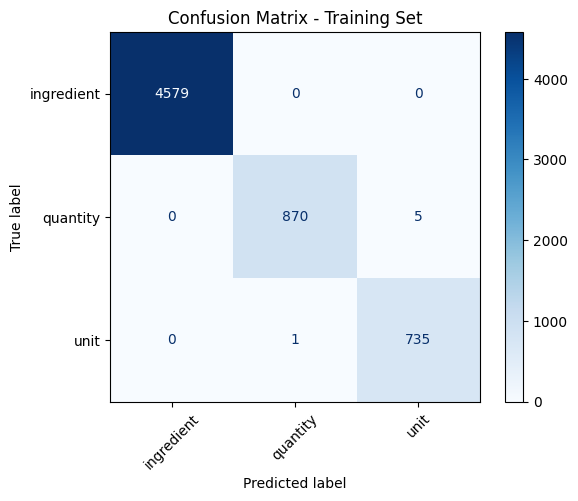

In [80]:
# create a confusion matrix on training datset
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
labels = sorted(list(set(y_train_true_flat)))

cm = confusion_matrix(y_train_true_flat, y_train_pred_flat, labels=labels)
import matplotlib.pyplot as plt

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap='Blues', xticks_rotation=45)
plt.title("Confusion Matrix - Training Set")
plt.show()

### **7.3** *Save the CRF model* <font color = red>[1 marks]</font>
Save the CRF model

In [81]:
# dump the model using joblib as crf_model.pkl

import joblib
joblib.dump(crf, 'crf_model.pkl')


['crf_model.pkl']

## **8** Prediction and Model Evaluation <font color = red>[3 marks]</font> <br>

### **8.1** *Predict and Evaluate the CRF model on validation set* <font color = red>[3 marks]</font>
Evaluate the metrics for CRF model by using flat classification report and confusion matrix




In [82]:
# predict the crf model on validation dataset
y_val_pred = crf.predict(X_val_weighted_feature)

In [83]:
# specify flat classification report
y_val_true_flat = [label for sent in y_val_label for label in sent]
y_val_pred_flat = [label for sent in y_val_pred for label in sent]

print(classification_report(y_val_true_flat, y_val_pred_flat))

              precision    recall  f1-score   support

  ingredient       1.00      1.00      1.00      2137
    quantity       1.00      0.99      1.00       393
        unit       0.99      1.00      1.00       327

    accuracy                           1.00      2857
   macro avg       1.00      1.00      1.00      2857
weighted avg       1.00      1.00      1.00      2857



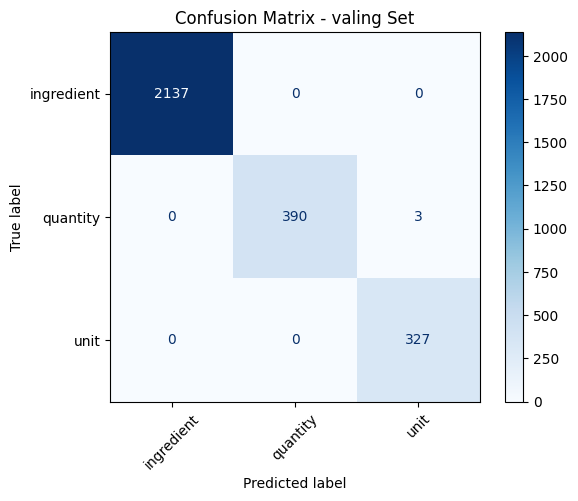

In [85]:
# create a confusion matrix on validation dataset
labels = sorted(list(set(y_val_true_flat)))

cm = confusion_matrix(y_val_true_flat, y_val_pred_flat, labels=labels)
import matplotlib.pyplot as plt

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap='Blues', xticks_rotation=45)
plt.title("Confusion Matrix - valing Set")
plt.show()

## **9** Error Analysis on Validation Data <font color = red>[10 marks]</font> <br>
Investigate misclassified samples in validation dataset and provide the insights


### **9.1** *Investigate misclassified samples in validation dataset* <font color = red>[8 marks]</font>



##### **9.1.1** Flatten the labels of validation data and initialise error data <font color = red>[2 marks]</font> <br>



Flatten the true and predicted labels and initialise the error data as ***error_data***

In [ ]:
# flatten Labels and Initialise Error Data


##### **9.1.2** Iterate the validation data and collect Error Information<font color = red> [2 marks]</font> <br>



Iterate through validation data (X_val, y_val_labels, y_pred_val) and compare true vs. predicted labels. Collect error details, including surrounding context, previous/next tokens, and class weights, then store them in error_data

In [ ]:
# iterate and collect Error Information

            # get previous and next tokens with handling for boundary cases


##### **9.1.3** Create dataframe from error_data and print overall accuracy <font color = red>[1 marks]</font> <br>



Change error_data into dataframe and then use it to illustrate the overall accuracy of validation data

In [ ]:
# Create DataFrame and Print Overall Accuracy


##### **9.1.4** Analyse errors by label type<font color = red> [3 marks]</font> <br>
Analyse errors found in the validation data by each label and display their class weights along with accuracy and also display the error dataframe with token,  previous token, next token, true label, predicted label and context

In [ ]:
# Analyse errors found in the validation data by each label
# and display their class weights along with accuracy
# and display the error dataframe with token, previous token, next token, true label, predicted label and context



### **9.2** *Provide insights from the validation dataset* <font color = red>[2 marks]</font>




 <font color = red>[Write your answer]</font>

## **10** Conclusion (Optional) <font color = red>[0 marks]</font> <br>

Write your findings and conclusion.